In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False)

labels_df = pd.read_csv('train_v2.csv')

In [4]:
labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x else 0)

In [5]:
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)

In [6]:
train_df['image_name'] = train_df['image_name'].apply(lambda x: f"{x}.jpg")
val_df['image_name'] = val_df['image_name'].apply(lambda x: f"{x}.jpg")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation'],
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

data_dir = 'D:/DOWNLOADS/train-jpg/train-jpg'

train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)

Found 32383 validated image filenames.
Found 8096 validated image filenames.


In [12]:
from tensorflow.keras.layers import Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [14]:
history = model.fit(train_generator, epochs=3, validation_data=val_generator)

Epoch 1/3


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1012/1012 ━━━━━━━━━━━━━━━━━━━━ 900s 883ms/step - auc: 0.5409 - loss: 0.3378 - val_auc: 0.8334 - val_loss: 0.2874
Epoch 2/3
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 896s 885ms/step - auc: 0.6579 - loss: 0.2863 - val_auc: 0.8327 - val_loss: 0.2753
Epoch 3/3
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 894s 883ms/step - auc: 0.7001 - loss: 0.2829 - val_auc: 0.8376 - val_loss: 0.2644


In [15]:
from tensorflow.keras.preprocessing import image

def predict_deforestation(model, img_path, img_size=(224, 224)):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    preds = model.predict(x)

    return preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


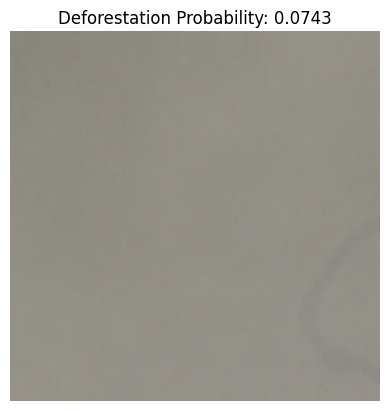

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


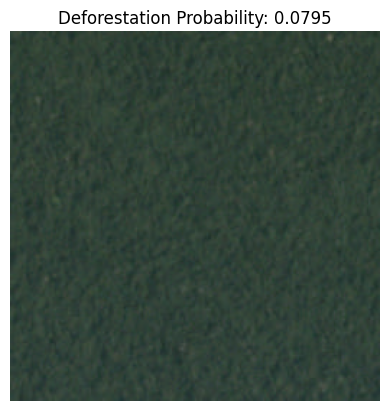

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


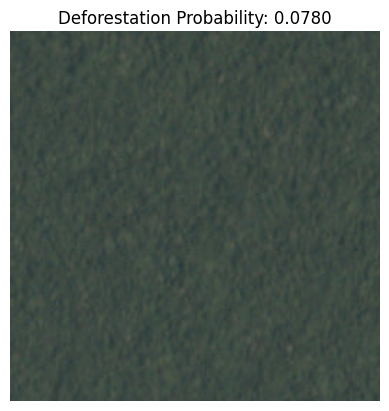

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


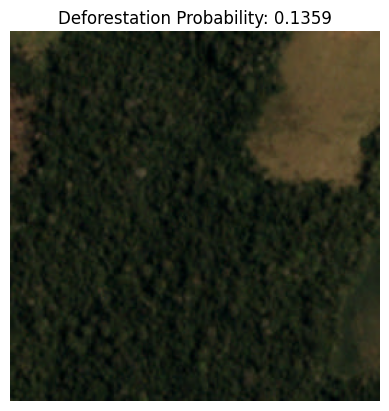

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


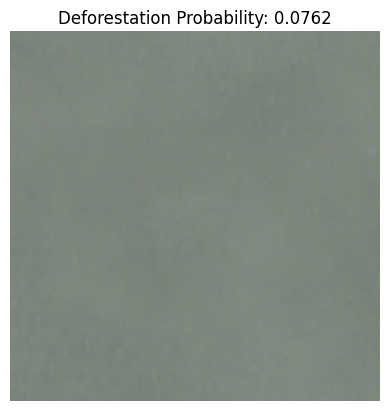

In [16]:
import os
import random
import matplotlib.pyplot as plt

def display_image_with_predictions(img_path, deforestation_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}")
    plt.axis("off")
    plt.show()

test_data_dir = 'D:/DOWNLOADS/test-jpg/test-jpg'

test_images = random.sample(os.listdir(test_data_dir), 5)

for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    preds = predict_deforestation(model, img_path)

    deforestation_prob = preds[0][0]

    display_image_with_predictions(img_path, deforestation_prob)
